### Project

***Given data***  
News articles in 4 categories  
- 120k train
- 7.6k test

***Ideas***  
1) Summarize news articles using Glove embeddings   (transfer learning-ish)
2) Compute and visualize PCA  
3) Construct and evaluate classifier of own choice  

4) Use given code to train classifier based on tri-gram embeddings  
5) Plot and visualize features  
6) Write own small news and visualize in plot  
7) Find nearest neighbor articles  
8) Compare this classifier with classifier in 3)  
9) Investigate how the embedding dimension affects the classifier and latent representation


***Other ideas***  
a) Try different data set? SPAM?
b) Investigate calibration of classifier  
c) ..?

In [27]:
%matplotlib inline

import pylab as plt
import seaborn as snb
import matplotlib.ticker as ticker

import numpy as np
import random

import time
import math
import string
from tqdm import tqdm

import torch
from torch import optim

import torchtext
from torchtext.datasets import text_classification

snb.set_style('darkgrid')

### Get data

In [348]:
train_dataset, test_dataset = torchtext.datasets.AG_NEWS(ngrams=3)
train_dataset2, test_dataset2 = torchtext.datasets.AG_NEWS(ngrams=1, include_unk=True)

120000lines [00:11, 10827.39lines/s]
120000lines [00:19, 6209.59lines/s]
7600lines [00:01, 6848.15lines/s]
120000lines [00:03, 36320.65lines/s]
120000lines [00:05, 23473.76lines/s]
7600lines [00:00, 21685.83lines/s]


In [18]:
ag_news_label = {0 : "World",
                 1 : "Sports",
                 2 : "Business",
                 3 : "Sci/Tec"}


### Extract data from pytorch

In [9]:
from tqdm import tqdm

train_texts = []
test_texts = []
train_labels = []
test_labels = []

def get_text(tokens, voc):
    return  ' '.join([voc.itos[token] for token in tokens])


for i in tqdm(range(len(train_dataset2._data))):
    true_label, tokens = train_dataset2._data[i]
    text = get_text(tokens, train_dataset2.get_vocab())
    
    train_texts.append(text)
    train_labels.append(true_label)

for i in tqdm(range(len(test_dataset2._data))):
    true_label, tokens = test_dataset2._data[i]
    text = get_text(tokens, test_dataset2.get_vocab())

    test_texts.append(text)
    test_labels.append(true_label)

100%|██████████| 7600/7600 [00:00<00:00, 13290.65it/s]


In [130]:
for i in range(5):
    j = np.random.choice(range(len(train_texts)))
    print('Category: %s' % ag_news_label[train_labels[j]])
    print(60*'-')
    print(train_texts[j])
    
    print('\n')

Category: World
------------------------------------------------------------
william surfs to his fathers rescue once again prince william has come riding to the rescue of the royals , this time on the crest of a wave . at the end of a week that saw his father accused of not wanting people to rise above their station


Category: Business
------------------------------------------------------------
f . d . a . panel says sex patch needs more testing a hormone patch that works to restore a woman ' s sex drive should not be approved until additional studies to determine its risk , federal health advisers said today .


Category: Business
------------------------------------------------------------
euro slips after zew , dollar awaits data london ( reuters ) - the euro slipped against the dollar and yen on tuesday after weaker-than-expected german investor confidence data , while the dollar was soft ahead of u . s . data , seen key for interest rate expectations .


Category: Sci/Tec
-----

# Classification using Glove Embeddings (transfer learning ish?)

### Load Glove

In [22]:
filename = "glove.6B.100d.txt"

dictionary = {}
with open(filename,'r', encoding='utf-8') as file:
    for line in file:
        elements = line.split();
        word = elements[0];
        vector = np.asarray(elements[1:],"float32")
        dictionary[word] = vector;

### Compute mean embedding for each sentence

In [23]:
feats_train = []
feats_test = []

def clean(text):
    return text.translate(str.maketrans('', '', string.punctuation)).lower()

for text in tqdm(train_texts):
    words = clean(text).split()
    feats_train.append(np.mean([dictionary[word] for word in words if word in dictionary], 0))
    

for text in tqdm(test_texts):
    words = clean(text).split()
    feats_test.append(np.mean([dictionary[word] for word in words if word in dictionary], 0))
    

100%|██████████| 7600/7600 [00:00<00:00, 19558.93it/s]


### Compute PCA

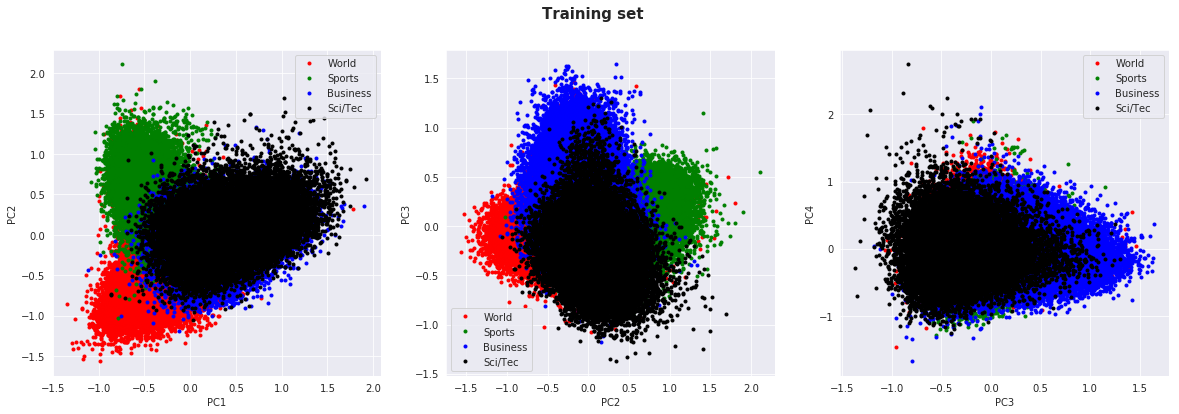

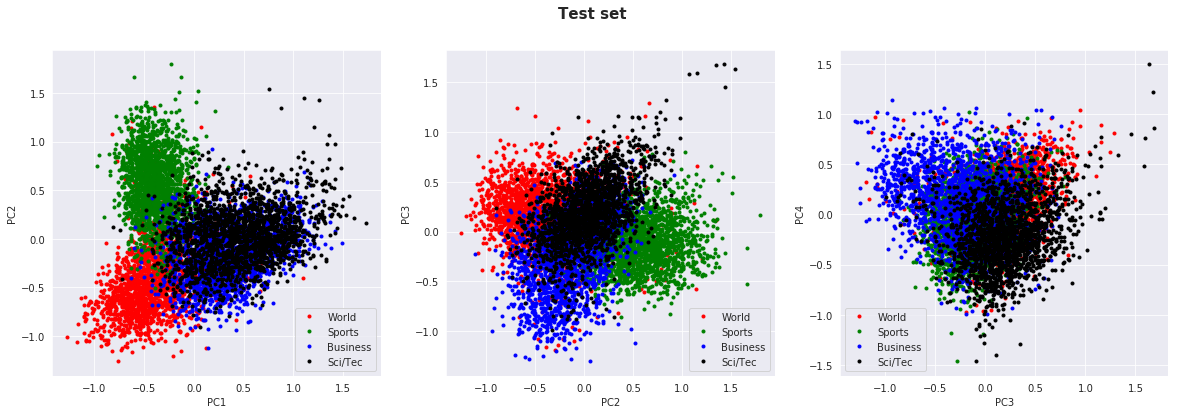

In [24]:
from sklearn.decomposition import PCA

feats_train = np.stack(feats_train)
feats_test = np.stack(feats_test)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

pca2 = PCA(n_components=4)
Vtrain = pca2.fit_transform(feats_train)
Vtest = pca2.fit_transform(feats_test)


colors = 'rgbk'
for c, Z, title in zip([train_labels, test_labels], [Vtrain, Vtest], ['Training set', 'Test set']):

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 3, 1)
    for i in range(4):
        plt.plot(Z[c==i, 0], Z[c==i, 1], '.', color=colors[i], label=ag_news_label[i])
    plt.legend()
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.subplot(1, 3, 2)
    for i in range(4):
        plt.plot(Z[c==i, 1], Z[c==i, 2], '.', color=colors[i], label=ag_news_label[i])
    plt.legend()
    plt.xlabel('PC2')
    plt.ylabel('PC3')

    plt.subplot(1, 3, 3)
    for i in range(4):
        plt.plot(Z[c==i, 2], Z[c==i, 3], '.', color=colors[i], label=ag_news_label[i])
    plt.legend()
    plt.xlabel('PC3')
    plt.ylabel('PC4')
    plt.suptitle(title, fontweight='bold', fontsize=15)


### Task: Apply and evaluate classifier of own choice?

In [162]:
from scipy.stats import multivariate_normal as mvn
means = []
covs = []


Z, c = Vtrain, train_labels
for i in range(4):
    means.append(np.mean(Z[c==i, :], axis=0))
    covs.append(np.cov(Z[c==i, :].T))

    

In [163]:
logps = np.zeros((len(test_labels), 4))

# assuming equal priors
for n in tqdm(range(len(test_labels))):
    for i in range(4):
        logps[n, i] = mvn.logpdf(Vtest[n, :], means[i], covs[i])
        
pred = np.argmax(logps, axis=1)

100%|██████████| 7600/7600 [00:02<00:00, 2590.81it/s]


In [164]:
print('Test accuracy: %3.2f' % np.mean(pred == test_labels))

Test accuracy: 0.59


# Text Classification using 3-gram embeddings

In [29]:
import torch.nn as nn
import torch.nn.functional as F
class TextClassification(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [292]:
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(train_dataset.get_labels())
model = TextClassification(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

In [293]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [294]:
from torch.utils.data import DataLoader

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

In [295]:
import time
from torch.utils.data.dataset import random_split
N_EPOCHS = 5
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

Epoch: 1  | time in 0 minutes, 45 seconds
	Loss: 0.0284(train)	|	Acc: 83.0%(train)
	Loss: 0.0000(valid)	|	Acc: 89.2%(valid)
Epoch: 2  | time in 0 minutes, 54 seconds
	Loss: 0.0105(train)	|	Acc: 94.5%(train)
	Loss: 0.0000(valid)	|	Acc: 90.4%(valid)
Epoch: 3  | time in 0 minutes, 50 seconds
	Loss: 0.0042(train)	|	Acc: 98.1%(train)
	Loss: 0.0000(valid)	|	Acc: 90.3%(valid)
Epoch: 4  | time in 0 minutes, 54 seconds
	Loss: 0.0019(train)	|	Acc: 99.3%(train)
	Loss: 0.0000(valid)	|	Acc: 91.6%(valid)
Epoch: 5  | time in 0 minutes, 49 seconds
	Loss: 0.0012(train)	|	Acc: 99.6%(train)
	Loss: 0.0000(valid)	|	Acc: 91.6%(valid)


In [296]:
print('Checking the results of test dataset...')
test_loss, test_acc = test(test_dataset)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

Checking the results of test dataset...
	Loss: 0.0003(test)	|	Acc: 79.5%(test)


In [297]:
import re
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer


def predict(text, model, vocab, ngrams, return_top=False, return_output=False):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        output = model(text, torch.tensor([0]))
        if return_top:
            topv, topi = output.topk(4, 1, True)
            topv = topv.detach().numpy()
            topi = topi.detach().numpy()
            return topv, topi
        elif return_output:
            return output
        else:
            return output.argmax(1).item()

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

vocab = train_dataset.get_vocab()
model = model.to("cpu")

print("This is a %s news" %ag_news_label[predict(ex_text_str, model, vocab, 2)])

This is a Sports news


### PCA (try both training and test sets)

In [37]:
Xtrain, Xtest = [], []
ctrain, ctest = [], []

data = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=generate_batch)
for text, offsets, cls in data:
    
    output = model.embedding(text, offsets)
    
    Xtrain.append(output.detach().numpy())
    ctrain.append(cls.detach().numpy())
    

data = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=generate_batch)
for text, offsets, cls in data:
    
    output = model.embedding(text, offsets)
    
    Xtest.append(output.detach().numpy())
    ctest.append(cls.detach().numpy())
        

In [38]:
Xtrain = np.vstack(Xtrain)
Xtest = np.vstack(Xtest)
ctrain = np.hstack(ctrain)
ctest = np.hstack(ctest)


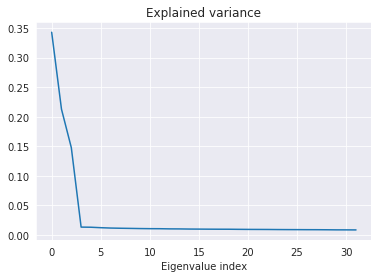

In [118]:
from sklearn.decomposition import PCA

pca = PCA(n_components=32)

Ztrain = pca.fit_transform(Xtrain)
Ztest = pca.transform(Xtest)

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Eigenvalue index')
plt.title('Explained variance')

pca = PCA(n_components=4)

Ztrain = pca.fit_transform(Xtrain)
Ztest = pca.transform(Xtest)

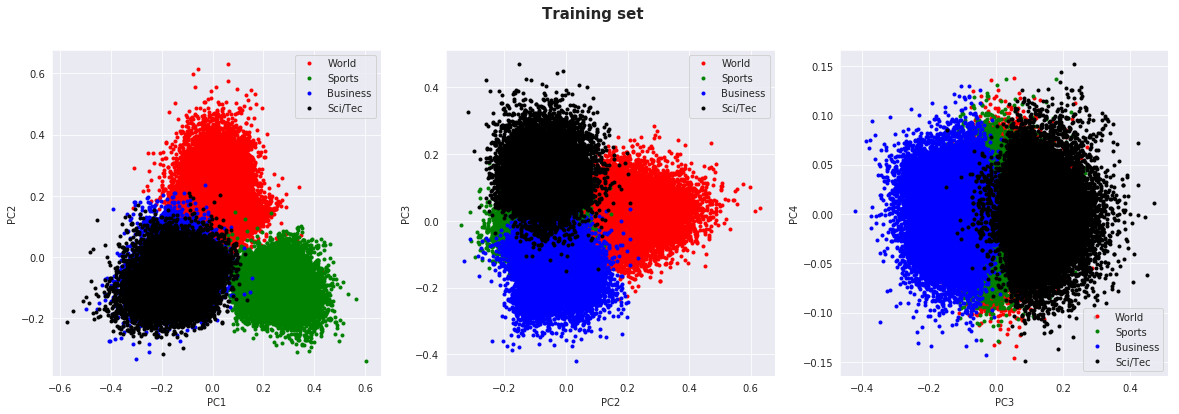

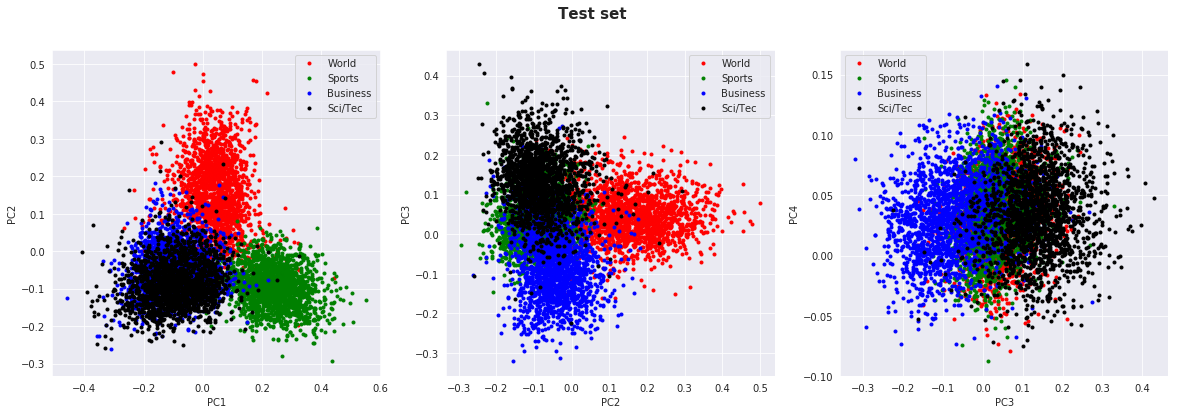

In [92]:
colors = 'rgbk'
for c, Z, title in zip([ctrain, ctest], [Ztrain, Ztest], ['Training set', 'Test set']):

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 3, 1)
    for i in range(4):
        plt.plot(Z[c==i, 0], Z[c==i, 1], '.', color=colors[i], label=ag_news_label[i])
    plt.legend()
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.subplot(1, 3, 2)
    for i in range(4):
        plt.plot(Z[c==i, 1], Z[c==i, 2], '.', color=colors[i], label=ag_news_label[i])
    plt.legend()
    plt.xlabel('PC2')
    plt.ylabel('PC3')

    plt.subplot(1, 3, 3)
    for i in range(4):
        plt.plot(Z[c==i, 2], Z[c==i, 3], '.', color=colors[i], label=ag_news_label[i])
    plt.legend()
    plt.xlabel('PC3')
    plt.ylabel('PC4')
    plt.suptitle(title, fontweight='bold', fontsize=15)


### My text

In [237]:
#my_text = 'The team suffered a great and very surprising defeat.'# It was a crisis situation, people were losing big money.'
my_text = 'Apple presents the newest smarthpone with more features than ever'

In [238]:
print('Text: %s\n\n' % my_text)


topv, topi = predict(my_text, model, vocab, 2, return_top=True)

print('Rank\tCategory\tScore')
print(60*'-')
for rank in range(4):
    print('#%d\t%-15s (%3.2f)' % (rank+1, ag_news_label[topi[0, rank]], topv[0, rank]))



Text: Apple presents the newest smarthpone with more features than ever


Rank	Category	Score
------------------------------------------------------------
#1	Sci/Tec         (18.20)
#2	Business        (-2.82)
#3	Sports          (-5.58)
#4	World           (-9.78)


### Own "news" in the PCA plot

In [239]:
def my_predict(text, model, vocab, ngrams):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        emb = model.embedding(text, torch.LongTensor([0]))
        return emb
    

Text(0, 0.5, 'PC4')

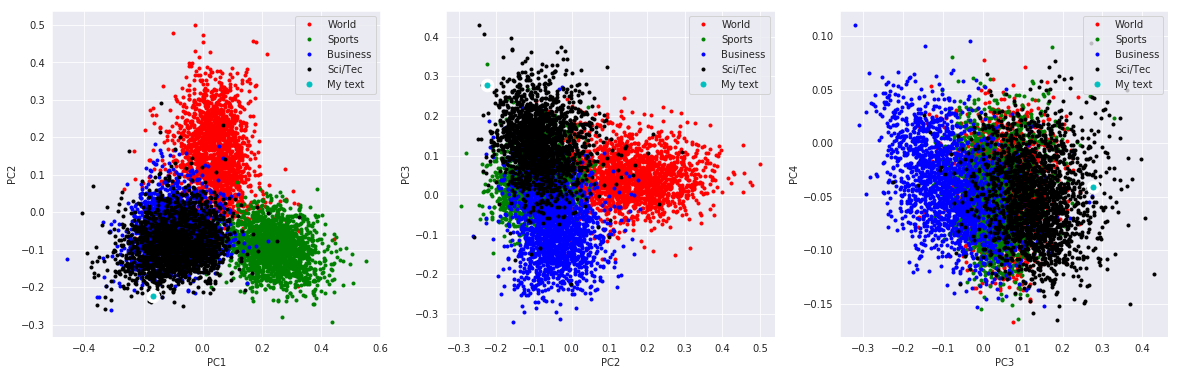

In [240]:


Z, c = Ztest, ctest

my_X = my_predict(my_text, model, vocab, 2)
my_Z = pca.transform(my_X)


plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
for i in range(4):
    plt.plot(Z[c==i, 0], Z[c==i, 1], '.', color=colors[i], label=ag_news_label[i])
plt.plot(my_Z[0, 0], my_Z[0, 1], 'w.', markersize=25)
plt.plot(my_Z[0, 0], my_Z[0, 1], 'c.', label='My text', markersize=10)
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
    
plt.subplot(1, 3, 2)
for i in range(4):
    plt.plot(Z[c==i, 1], Z[c==i, 2], '.', color=colors[i], label=ag_news_label[i])
plt.plot(my_Z[0, 1], my_Z[0, 2], 'w.', markersize=25)
plt.plot(my_Z[0, 1], my_Z[0, 2], 'c.', label='My text', markersize=10)
plt.legend()
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.subplot(1, 3, 3)
for i in range(4):
    plt.plot(Z[c==i, 2], Z[c==i, 3], '.', color=colors[i], label=ag_news_label[i])
plt.plot(my_Z[0, 2], my_Z[0, 3], 'w.', markersize=25)
plt.plot(my_Z[0, 2], my_Z[0, 3], 'c.', label='My text', markersize=10)
plt.legend()
plt.xlabel('PC3')
plt.ylabel('PC4')



### Nearest neighbor

In [241]:
from scipy.spatial.distance import cosine

dists = [cosine(my_Z, Zi) for Zi in Z]

best_idx = np.argmin(dists)

voc = test_dataset2.get_vocab()
label, tokens = test_dataset2._data[best_idx]


In [242]:
print('My text')
print(50*'-')
print(my_text)
print('\n\n')


s = get_text(tokens, test_dataset2.get_vocab())
print('Nearest neighbor (cos. dist = %3.2f)' % dists[best_idx])
print(50*'-')
print(s)
print('\n\n')
print('True label: %s' % ag_news_label[label])

My text
--------------------------------------------------
Apple presents the newest smarthpone with more features than ever



Nearest neighbor (cos. dist = 0.00)
--------------------------------------------------
sun ' s looking glass provides 3d view developers get early code for new operating system ' skin ' still being crafted .



True label: Sci/Tec


### Plot nearest neighbor in PCA

Text(0, 0.5, 'PC4')

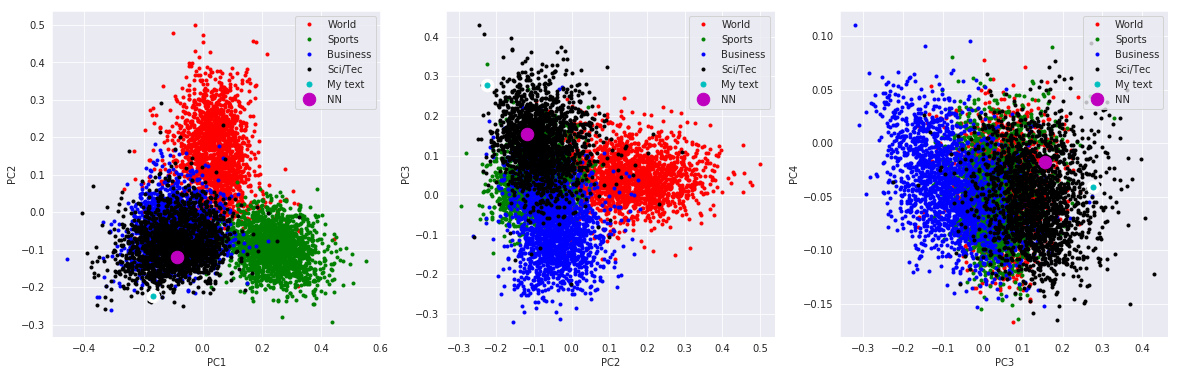

In [243]:

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
for i in range(4):
    plt.plot(Z[c==i, 0], Z[c==i, 1], '.', color=colors[i], label=ag_news_label[i])
plt.plot(my_Z[0, 0], my_Z[0, 1], 'w.', markersize=25)
plt.plot(my_Z[0, 0], my_Z[0, 1], 'c.', label='My text', markersize=10)
plt.plot(Z[best_idx, 0], Z[best_idx, 1], 'm.', markersize=25, label='NN')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
    
plt.subplot(1, 3, 2)
for i in range(4):
    plt.plot(Z[c==i, 1], Z[c==i, 2], '.', color=colors[i], label=ag_news_label[i])
plt.plot(my_Z[0, 1], my_Z[0, 2], 'w.', markersize=25)
plt.plot(my_Z[0, 1], my_Z[0, 2], 'c.', label='My text', markersize=10)
plt.plot(Z[best_idx, 1], Z[best_idx, 2], 'm.', markersize=25, label='NN')
plt.legend()
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.subplot(1, 3, 3)
for i in range(4):
    plt.plot(Z[c==i, 2], Z[c==i, 3], '.', color=colors[i], label=ag_news_label[i])
plt.plot(my_Z[0, 2], my_Z[0, 3], 'w.', markersize=25)
plt.plot(my_Z[0, 2], my_Z[0, 3], 'c.', label='My text', markersize=10)
plt.plot(Z[best_idx, 2], Z[best_idx, 3], 'm.', markersize=25, label='NN')
plt.legend()
plt.xlabel('PC3')
plt.ylabel('PC4')



### Calibration curves

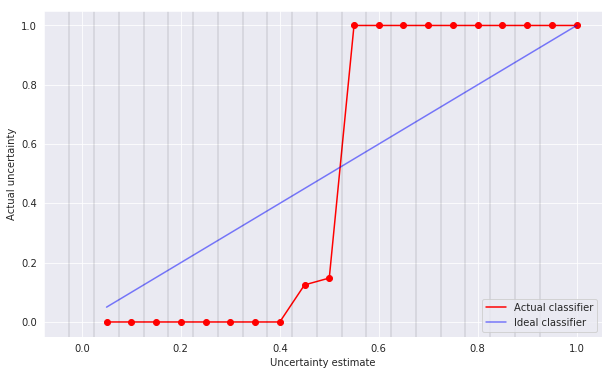

In [142]:
probs = []
correct = []
sm = nn.Softmax(dim=1)

for i in range(len(test_dataset2._data)):

    true_label, tokens = test_dataset2._data[i]
    text = get_text(tokens, voc)

    output = predict(text, model, vocab, 2, return_output=True)
    prob = sm(output)
    probs.append(prob[0, true_label].item())
    correct.append(1.0*(output.argmax(1).item() == true_label))



probs = np.array(probs)
correct = np.array(correct)

pairs = list(zip(probs, correct))

def in_interval(x, a, b):
    return a <= x < b

end_points = np.linspace(0, 0.95, 20)

intervals = [(ep, ep+0.05) for ep in end_points]

accs = []
counts = []

for a,b in intervals:
    vals = [cor for p, cor in pairs if in_interval(p, a, b)]
    if len(vals) > 0:
        acc = np.mean(vals)
    else:
        acc = 0
        
    counts.append(len(vals))
            
    accs.append(acc)
    

plt.figure(figsize=(10, 6))
plt.plot(end_points+0.05, accs, 'r', label='Actual classifier')
plt.plot(end_points+0.05, accs, 'r.', markersize=12)
plt.plot(end_points+0.05, end_points+.05, 'b-', alpha=0.5, label='Ideal classifier')
for p in end_points:
    plt.axvline(p-0.025, color='k', linestyle='-', alpha=0.1)
plt.xlabel('Uncertainty estimate')
plt.ylabel('Actual uncertainty')
plt.legend()

### QUick and dirty code for loading SPAM data

In [379]:
import pandas as pd
data = pd.read_csv('./SMSSpamCollection', delimiter='\t', header=None)


spamlabel = data[0]
spamtext = data[1]
Nspam = len(spamlabel)

FileNotFoundError: [Errno 2] File b'./SMSSpamCollection' does not exist: b'./SMSSpamCollection'

In [380]:
Ntrain = int(0.5*Nspam)

spam_train_idx = np.random.choice(range(Nspam), size=Ntrain, replace=False)
spam_test_idx = np.setdiff1d(range(Nspam), spam_train_idx)

spamlabel_train = spamlabel[spam_train_idx]
spamlabel_test = spamlabel[spam_test_idx]

spamtext_train = spamtext[spam_train_idx]
spamtext_test = spamtext[spam_test_idx]

f = open('./spam_train.csv', "w")
for label, text in zip(spamlabel_train, spamtext_train):
    if label == 'spam':
        f.write('"%d", "%s"\n' % (1, text))
    else:
        f.write('"%d","%s"\n' % (0, text))
f.close()

f = open('./spam_test.csv', "w")
for label, text in zip(spamlabel_test, spamtext_test):
    if label == 'spam':
        f.write('"%d", "%s"\n' % (1, text))
    else:
        f.write('"%d", "%s"\n' % (0, text))
f.close()

In [381]:
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.utils import download_from_url, extract_archive, unicode_csv_reader
from torchtext.vocab import Vocab
import io

def _csv_iterator(data_path, ngrams, yield_cls=False):
    tokenizer = get_tokenizer("basic_english")
    with io.open(data_path, encoding="utf8") as f:
        reader = unicode_csv_reader(f)
        for row in reader:
            tokens = ' '.join(row[1:])
            tokens = tokenizer(tokens)
            if yield_cls:
                yield int(row[0]), ngrams_iterator(tokens, ngrams)
            else:
                yield ngrams_iterator(tokens, ngrams)


def _create_data_from_iterator(vocab, iterator, include_unk):
    data = []
    labels = []
    with tqdm(unit_scale=0, unit='lines') as t:
        for cls, tokens in iterator:
            if include_unk:
                tokens = torch.tensor([vocab[token] for token in tokens])
            else:
                token_ids = list(filter(lambda x: x is not Vocab.UNK, [vocab[token]
                                        for token in tokens]))
                tokens = torch.tensor(token_ids)
            if len(tokens) == 0:
                logging.info('Row contains no tokens.')
            data.append((cls, tokens))
            labels.append(cls)
            t.update(1)
    return data, set(labels)



def prep_spam_data(spam_vocab=None, ngrams=3, include_unk=True):
    train_csv_path = './spam_train.csv'
    test_csv_path = './spam_test.csv'

    if spam_vocab is None:
        spam_vocab = build_vocab_from_iterator(_csv_iterator(train_csv_path, ngrams))
        
    train_data, train_labels = _create_data_from_iterator(spam_vocab, _csv_iterator(train_csv_path, ngrams, yield_cls=True), include_unk)
    test_data, test_labels = _create_data_from_iterator(spam_vocab, _csv_iterator(test_csv_path, ngrams, yield_cls=True), include_unk)

    spamdata_train = torchtext.datasets.TextClassificationDataset(spam_vocab, train_data, train_labels)
    spamdata_test = torchtext.datasets.TextClassificationDataset(spam_vocab, test_data, test_labels)
    
    return spamdata_train, spamdata_test 
    
# use vocab from pretrained model
spamdata_train, spamdata_test = prep_spam_data(spam_vocab=vocab, ngrams=3, include_unk=True)

2784lines [00:00, 15109.93lines/s]
2783lines [00:00, 15472.62lines/s]


### Map spam data through model trained on news data

In [398]:
Xspam_train = []
cspam_train = []

data = DataLoader(spamdata_train, batch_size=BATCH_SIZE, collate_fn=generate_batch)
for text, offsets, cls in data:
    
    output = model.embedding(text, offsets)
    
    Xspam_train.append(output.detach().numpy())
    cspam_train.append(cls.detach().numpy())

Xspam_train = np.vstack(Xspam_train)
cspam_train = np.hstack(cspam_train)

pca = PCA(n_components=4)
Zspam_train = pca.fit_transform(Xspam_train)

Text(0, 0.5, 'PC4')

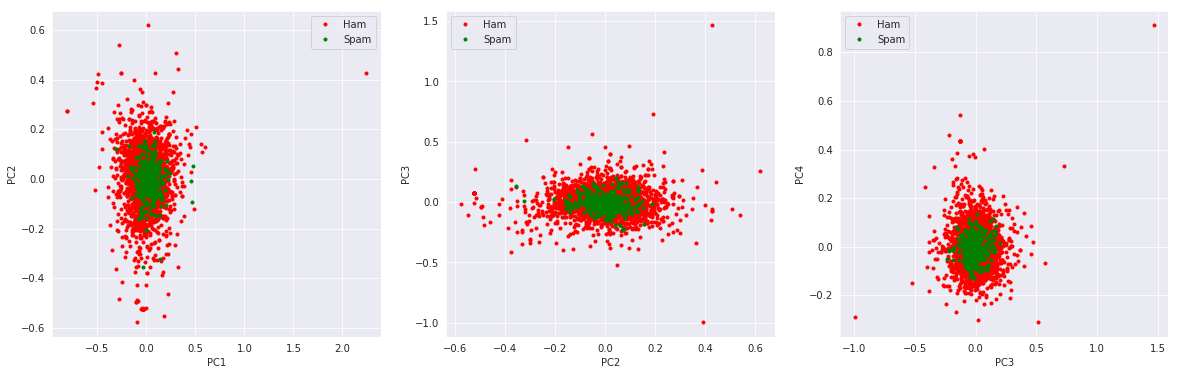

In [399]:
spam_labels=['Ham', 'Spam']

Z, c = Zspam_train, cspam_train




plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
for i in range(2):
    plt.plot(Z[c==i, 0], Z[c==i, 1], '.', color=colors[i], label=spam_labels[i])
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')


    
plt.subplot(1, 3, 2)
for i in range(2):
    plt.plot(Z[c==i, 1], Z[c==i, 2], '.', color=colors[i], label=spam_labels[i])
plt.legend()
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.subplot(1, 3, 3)
for i in range(2):
    plt.plot(Z[c==i, 2], Z[c==i, 3], '.', color=colors[i], label=spam_labels[i])
plt.legend()
plt.xlabel('PC3')
plt.ylabel('PC4')



### Quick and dirty code for training model on SPAM data

In [400]:
# use own vocab
spamdata_train, spamdata_test = prep_spam_data(spam_vocab=None, ngrams=3, include_unk=True)

2784lines [00:00, 29322.33lines/s]
2784lines [00:00, 15687.54lines/s]
2783lines [00:00, 17244.83lines/s]


In [401]:
spammodel = TextClassification(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

In [402]:

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        spamoptimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = spammodel(text, offsets)
        loss = spamcriterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        spamoptimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()
        

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = spammodel(text, offsets)
            loss = spamcriterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()
            

    return loss / len(data_), acc / len(data_)

In [403]:

spamcriterion = torch.nn.CrossEntropyLoss().to(device)
spamoptimizer = torch.optim.SGD(spammodel.parameters(), lr=4.0)
spamscheduler = torch.optim.lr_scheduler.StepLR(spamoptimizer, 1, gamma=0.9)

train_len = int(len(spamdata_train) * 0.95)
sub_train_, sub_valid_ = \
    random_split(spamdata_train, [train_len, len(spamdata_train) - train_len])

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

Epoch: 1  | time in 0 minutes, 0 seconds
	Loss: 0.0233(train)	|	Acc: 86.1%(train)
	Loss: 0.0014(valid)	|	Acc: 89.3%(valid)
Epoch: 2  | time in 0 minutes, 0 seconds
	Loss: 0.0092(train)	|	Acc: 95.0%(train)
	Loss: 0.0007(valid)	|	Acc: 93.6%(valid)
Epoch: 3  | time in 0 minutes, 0 seconds
	Loss: 0.0040(train)	|	Acc: 98.8%(train)
	Loss: 0.0002(valid)	|	Acc: 97.1%(valid)
Epoch: 4  | time in 0 minutes, 0 seconds
	Loss: 0.0023(train)	|	Acc: 99.2%(train)
	Loss: 0.0002(valid)	|	Acc: 96.4%(valid)
Epoch: 5  | time in 0 minutes, 0 seconds
	Loss: 0.0013(train)	|	Acc: 99.7%(train)
	Loss: 0.0001(valid)	|	Acc: 96.4%(valid)


In [404]:
print('Checking the results of test dataset...')
test_loss, test_acc = test(spamdata_test)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

Checking the results of test dataset...
	Loss: 0.0000(test)	|	Acc: 95.1%(test)


### Note test set accuracy seems fragile

### PCA again

In [405]:
Xspam_train = []
cspam_train = []

data = DataLoader(spamdata_train, batch_size=BATCH_SIZE, collate_fn=generate_batch)
for text, offsets, cls in data:
    
    output = spammodel.embedding(text, offsets)
    
    Xspam_train.append(output.detach().numpy())
    cspam_train.append(cls.detach().numpy())

Xspam_train = np.vstack(Xspam_train)
cspam_train = np.hstack(cspam_train)


Zspam_train = pca.fit_transform(Xspam_train)

Text(0, 0.5, 'PC4')

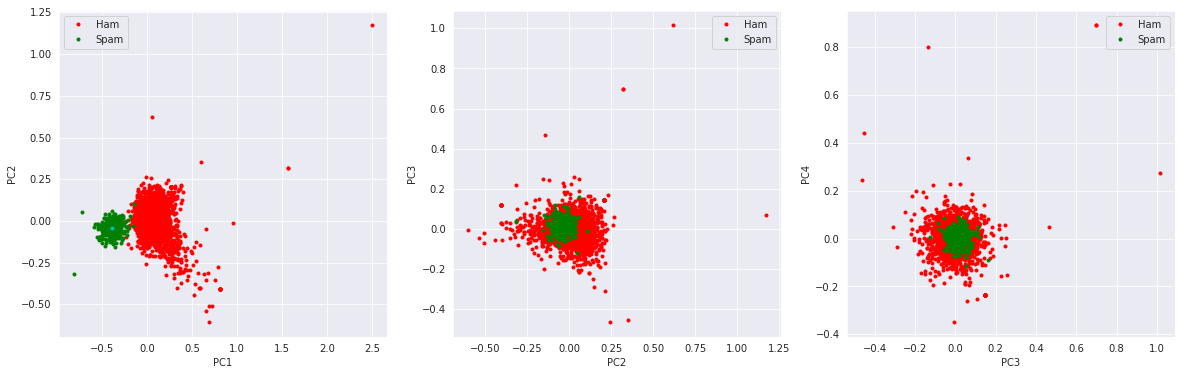

In [407]:
spam_labels=['Ham', 'Spam']

Z, c = Zspam_train, cspam_train

p = np.mean(Z[c==1,:], 0)


plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
for i in range(2):
    plt.plot(Z[c==i, 0], Z[c==i, 1], '.', color=colors[i], label=spam_labels[i])
    
plt.plot(p[0], p[1], 'c.')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')



    
plt.subplot(1, 3, 2)
for i in range(2):
    plt.plot(Z[c==i, 1], Z[c==i, 2], '.', color=colors[i], label=spam_labels[i])
plt.legend()
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.subplot(1, 3, 3)
for i in range(2):
    plt.plot(Z[c==i, 2], Z[c==i, 3], '.', color=colors[i], label=spam_labels[i])
plt.legend()
plt.xlabel('PC3')
plt.ylabel('PC4')





### Map mean (cyan point in the plot above) back to embedding space

In [409]:
Xp = pca.inverse_transform(p)
Xp.shape

(32,)

torch.Size([4045111, 32])

In [436]:
spam_vocab = spamdata_train.get_vocab()

In [437]:
dists = []

for i in range(len(spam_vocab.itos)):
    emb = spammodel.embedding.weight[i]
    dists.append(cosine(Xp, emb.detach().numpy()))

In [447]:
sort_idx = np.argsort(dists)
for rank in range(100):
    j = sort_idx[rank]
    term = spam_vocab.itos[j]
    print('#%2d\t%-15s (%3.2f)' % (rank+1, term, dists[j]))

# 1	txt             (0.13)
# 2	call            (0.13)
# 3	stop            (0.14)
# 4	free            (0.16)
# 5	claim           (0.19)
# 6	www .           (0.21)
# 7	reply           (0.21)
# 8	text            (0.24)
# 9	&               (0.28)
#10	word to         (0.30)
#11	. call          (0.32)
#12	mobile          (0.33)
#13	. co            (0.34)
#14	! your          (0.34)
#15	tone            (0.35)
#16	service         (0.35)
#17	!               (0.35)
#18	rain soon       (0.37)
#19	hear .          (0.37)
#20	. co .          (0.37)
#21	will be stifled (0.37)
#22	with            (0.38)
#23	www             (0.38)
#24	per             (0.39)
#25	50              (0.39)
#26	no extra charge (0.39)
#27	inconsiderate of me (0.39)
#28	txt nok to      (0.40)
#29	and honest      (0.40)
#30	po              (0.40)
#31	to draw in      (0.40)
#32	meaning .       (0.40)
#33	dun meet        (0.40)
#34	spageddies lor . (0.41)
#35	enjoy ur crushes (0.41)
#36	new             (0.41)
#37	out with quizzes (

Text(0, 0.5, 'PC2')

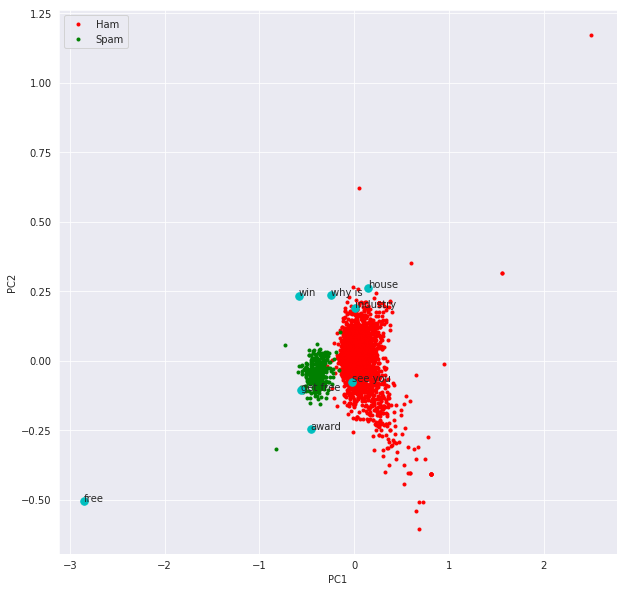

In [485]:
spam_labels=['Ham', 'Spam']

Z, c = Zspam_train, cspam_train

test_phrases= ['get free',  'free', 'win', 'award', 'industry', 'see you', 'why is', 'house']



plt.figure(figsize=(10, 10))
for i in range(2):
    plt.plot(Z[c==i, 0], Z[c==i, 1], '.', color=colors[i], label=spam_labels[i])

for test_phrase in test_phrases:
    p1 = pca.transform(spammodel.embedding.weight[spam_vocab.stoi[test_phrase]].detach().numpy().reshape(1, -1))
    plt.plot(p1[0,0], p1[0,1], 'c.', markersize=15)
    plt.text(p1[0,0], p1[0,1], test_phrase)
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')



In [463]:
spammodel.embedding.weight[spam_vocab.stoi[test_word]].detach().numpy().reshape(-1, 1).shape

(32, 1)